In [1]:
import sys
from pathlib import Path
# add project_root/src to sys.path
src_folder = Path.cwd().parent       # this is project_root/src
sys.path.insert(0, str(src_folder))
# Now Python knows to look inside project_root/src for modules.
from util import filter
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng(42) #random number generator

params = {
    # —— Glucose subsystem (eq. 27) —————————————————————
    "PG"      : 0.022,      # 1/min
    "Si"      : 1.2e-4,     # 1/min
    "alpha_G" : 1.0,        # 1/(mU·L⁻¹)
    "EGPb"    : 1.27,       # mmol/min  (0.0161 mmol⋅kg⁻¹⋅min⁻¹ × 79 kg)
    "CNS"     : 1.16,       # mmol/min
    "VG"      : 10.0,       # L

    # —— Insulin transport (eqs. 28:29) —————————————————
    "nI"      : 0.157,      # 1/min
    "nC"      : 0.0159,     # 1/min
    "nK"      : 0.0165,     # 1/min
    "nL"      : 0.003,      # 1/min
    "alpha_I" : 0.18,       # 1/(mU·L⁻¹)
    "VI"      : 11.0,       # L
    "xL"      : 0.60,       # unitless

    # —— Endogenous insulin (eq. 32) ——————————————————
    "k1"      : 210,        # mU/min
    "k2"      : 300,        # mU/L
    "k3"      : 0.007,      # unitless

    # —— Stomach / gut (eqs. 30–31) ————————————————
    "d1"      : 0.05,       # 1/min
    "d2"      : 0.06,       # 1/min
    "Pmax"    : 1.50,       # mmol/min
    "PN"      : 0.011,      # mmol/min  (0.2 mg/min ÷ 180 mg/mmol)

    # —— Interstitial glucose (eq. 34) ——————————————
    "beta1"   : 0.002,      # 1/min
    "beta2"   : 0.02,       # 1/min

    # —— Constant insulin infusion ——————————————————
    "uex"     : 58.91       # mU/min
}

def D_of_t(t_min):
    meal_starts = (7*60, 14*60, 21*60)      # min after midnight
    D_rate = 5 * (1000/180) / 40          # = 5.556 mmol/min
    return sum(D_rate for m in meal_starts if m <= t_min < m + 40)


def glucose_insulin_model(t, x, p):
    BG, IG, Q, I, P1, P2 = x
    P = p["PN"] + min(p["d2"] * P2, p["Pmax"])
    uen = p["k1"] * np.exp(-I / p["k2"]) + p["k3"]

    dBG = ( -p["PG"]*BG
            - p["Si"]*BG*Q/(1 + p["alpha_G"]*Q)
            + P
            + p["EGPb"]
            - p["CNS"] ) / p["VG"]

    dQ  = p["nI"]*(I - Q) - p["nC"]*Q/(1 + p["alpha_G"]*Q)

    dI  = ( -p["nK"]*I
            - p["nL"]*I/(1 + p["alpha_I"]*I)
            - p["nI"]*(I - Q)
            + p["uex"]/p["VI"]
            + (1 - p["xL"]) * uen / p["VI"] )

    dP1 = -p["d1"]*P1 + D_of_t(t)        # D_of_t defined below
    dP2 = -min(p["d2"]*P2, p["Pmax"]) + p["d1"]*P1
    dIG = p["beta1"]*BG - p["beta2"]*IG

    return [dBG, dIG, dQ, dI, dP1, dP2]


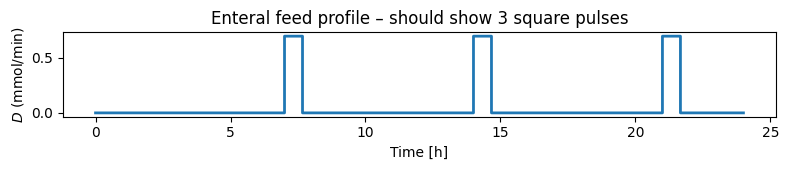

In [2]:
# ---- Sanity check: plot D(t) alone --------------------------------------
t_meal   = np.arange(0, 24*60+1)          # 48 h, 1-min grid
D_trace  = [D_of_t(t) for t in t_meal]

plt.figure(figsize=(8,1.8))
plt.step(t_meal/60, D_trace, where='post', lw=2)
plt.ylabel('$D$ (mmol/min)')
plt.xlabel('Time [h]')
plt.title('Enteral feed profile – should show 3 square pulses')
plt.tight_layout(); plt.show()


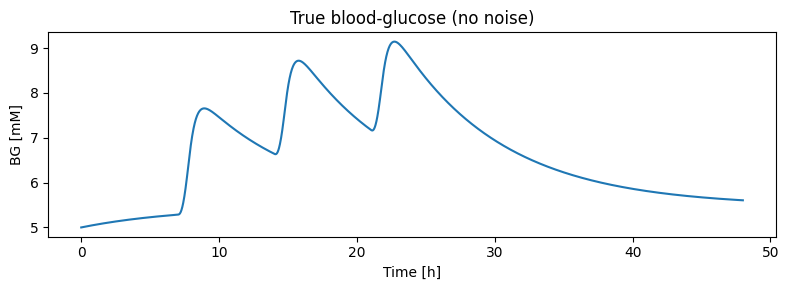

In [3]:
t_end = 48 * 60        # minutes (48 h)
dt    = 1
ts    = np.arange(0, t_end + dt, dt)

# Initial state vector: [BG, IG, Q, I, P1, P2]
x0 = np.array([5.0, 5.0, 74.0, 108.58, 0.0, 0.0])

solver = ode(lambda t, x: glucose_insulin_model(t, x, params))\
           .set_integrator('dopri5')
solver.set_initial_value(x0, 0)

xs = np.zeros((len(ts), 6))
xs[0] = x0
for k in range(1, len(ts)):
    xs[k] = solver.integrate(ts[k])

# Plot the true BG trajectory
plt.figure(figsize=(8, 3))
plt.plot(ts / 60, xs[:, 0], label='True BG')
plt.xlabel('Time [h]')
plt.ylabel('BG [mM]')
plt.title('True blood-glucose (no noise)')
plt.tight_layout()
plt.show()


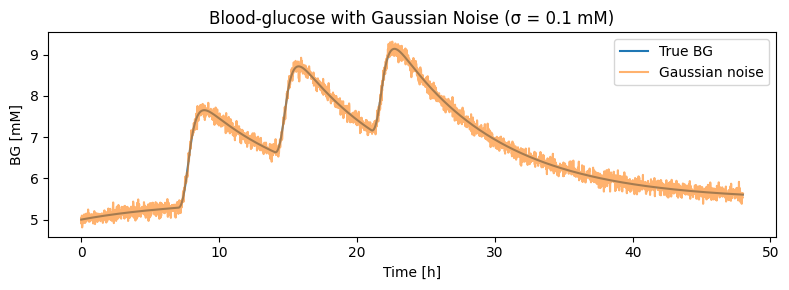

In [4]:
bg_true = xs[:, 0]
time_hours = ts / 60

sigma_gaussian = 0.1  # standard deviation in mmol/L (adjust as needed)
noise_gaussian = rng.normal(loc=0.0, scale=sigma_gaussian, size=bg_true.shape)
bg_gauss_noisy = bg_true + noise_gaussian

plt.figure(figsize=(8, 3))
plt.plot(time_hours, bg_true, label='True BG', color='tab:blue')
plt.plot(time_hours, bg_gauss_noisy, label='Gaussian noise', color='tab:orange', alpha=0.6)
plt.xlabel('Time [h]')
plt.ylabel('BG [mM]')
plt.title('Blood-glucose with Gaussian Noise (σ = 0.1 mM)')
plt.legend()
plt.tight_layout()
plt.show()

add non-Gaussian noise ?

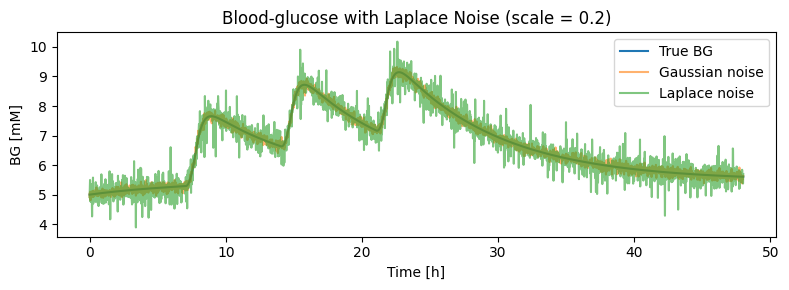

In [5]:
scale_laplace = 0.2  # scale parameter for Laplace (equivalent to σ for comparison)
noise_laplace = rng.laplace(loc=0.0, scale=scale_laplace, size=bg_true.shape)
bg_laplace_noisy = bg_true + noise_laplace

plt.figure(figsize=(8, 3))
plt.plot(time_hours, bg_true, label='True BG', color='tab:blue')
plt.plot(time_hours, bg_gauss_noisy, label='Gaussian noise', color='tab:orange', alpha=0.6)
plt.plot(time_hours, bg_laplace_noisy, label='Laplace noise', color='tab:green', alpha=0.6)
plt.xlabel('Time [h]')
plt.ylabel('BG [mM]')
plt.title('Blood-glucose with Laplace Noise (scale = 0.2)')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import os
# print current working directory
print("Current working directory:", os.getcwd())

# Change directory to the src folder
SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))  # project_root/src
print("Changing directory to:", SRC_PATH)
os.chdir(SRC_PATH)

# Import the KalmanFilter class from util.filter
from util.filter import KalmanFilter, KalmanNetFilter, ParticleFilter
print(KalmanFilter)
print(KalmanNetFilter)
print(ParticleFilter)

Current working directory: /home/ash/Desktop/kalman-net/src/notebooks
Changing directory to: /home/ash/Desktop/kalman-net/src
<class 'util.filter.KalmanFilter'>
<class 'util.filter.KalmanNetFilter'>
<class 'util.filter.ParticleFilter'>


/tmp/ipykernel_68514/214710214.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_gauss[k] = x_hat
/tmp/ipykernel_68514/214710214.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_laplace[k] = x_hat


Particle-filter RMSE : Gaussian noise : 0.053 mM
Particle-filter RMSE : Laplace noise  : 0.085 mM


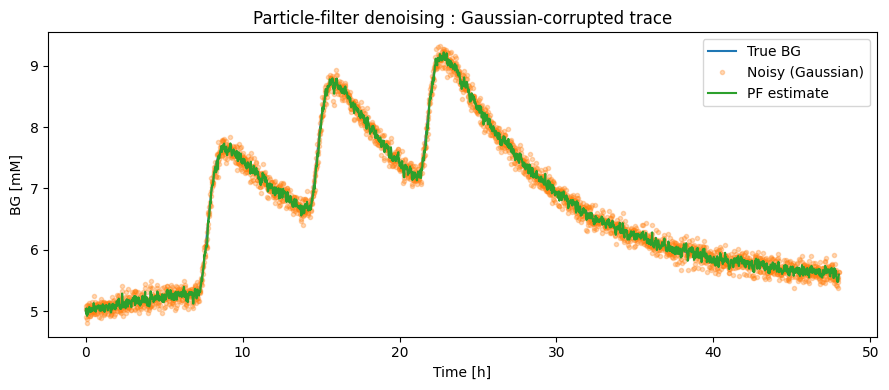

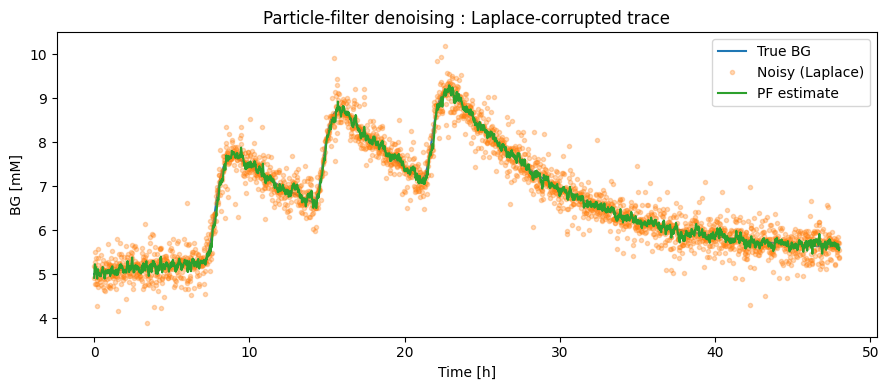

In [9]:
# ------------------------------------------------------------------------
# Particle-filter denoising of the CGM traces
# ---------------------------------------------------------------------------
from util.filter import ParticleFilter

# 1.  Model definition -------------------------------------------------------
dim_state   = 1                 # BG is a single scalar state
Q_STD       = 0.05              # process-noise σ  (tune to allow more / less drift)
SIGMA_G     = sigma_gaussian    # measurement σ for the Gaussian-noise trace
B_LAPLACE   = scale_laplace     # Laplace “b” parameter (= σ/√2)

def f_func(x_prev, w):
    """Random-walk process model:  Gₖ = Gₖ₋₁ + wₖ"""
    return x_prev + w           # x_prev and w are shape-(1,) arrays

def h_func(x, v):
    """Ideal CGM sensor: zₖ = Gₖ + vₖ"""
    return x + v

# Sampling helpers -----------------------------------------------------------
sample_process_noise = lambda: np.random.normal(0.0, Q_STD, (dim_state,))
sample_meas_noise_g  = lambda: np.random.normal(0.0, SIGMA_G, (dim_state,))
sample_meas_noise_l  = lambda: np.random.laplace(0.0, B_LAPLACE, (dim_state,))

# Likelihood functions -------------------------------------------------------
norm_coef     = 1.0 / (np.sqrt(2 * np.pi) * SIGMA_G)
laplace_coef  = 1.0 / (2.0 * B_LAPLACE)

def meas_like_gauss(z, x):
    """p(z | x) under N(x, σ²)"""
    return norm_coef * np.exp(-0.5 * ((z - x[0]) / SIGMA_G) ** 2)

def meas_like_laplace(z, x):
    """p(z | x) under Laplace(x, b)"""
    return laplace_coef * np.exp(-np.abs(z - x[0]) / B_LAPLACE)

# 2.  Instantiate one PF for each noise type ---------------------------------
N_PARTICLES  = 5_00
INIT_SPREAD  = 0.5              # stddev of initial guess (mM)

pf_gauss = ParticleFilter(
    N=N_PARTICLES,
    dim_state=dim_state,
    f_func=f_func,
    h_func=h_func,
    sample_process_noise=sample_process_noise,
    sample_meas_noise=sample_meas_noise_g,
    meas_likelihood=meas_like_gauss,
    init_particles=np.random.normal(bg_gauss_noisy[0],
                                    INIT_SPREAD,
                                    size=(N_PARTICLES, dim_state)),
)

pf_laplace = ParticleFilter(
    N=N_PARTICLES,
    dim_state=dim_state,
    f_func=f_func,
    h_func=h_func,
    sample_process_noise=sample_process_noise,
    sample_meas_noise=sample_meas_noise_l,
    meas_likelihood=meas_like_laplace,
    init_particles=np.random.normal(bg_laplace_noisy[0],
                                    INIT_SPREAD,
                                    size=(N_PARTICLES, dim_state)),
)

# 3.  Run the two filters -----------------------------------------------------
est_gauss   = np.empty_like(bg_gauss_noisy)
est_laplace = np.empty_like(bg_laplace_noisy)

for k, z in enumerate(bg_gauss_noisy):
    x_hat, _  = pf_gauss.step(z)
    est_gauss[k] = x_hat

for k, z in enumerate(bg_laplace_noisy):
    x_hat, _   = pf_laplace.step(z)
    est_laplace[k] = x_hat

# 4.  Optional RMSE sanity check ---------------------------------------------
rmse_gauss   = np.sqrt(np.mean((est_gauss   - bg_true) ** 2))
rmse_laplace = np.sqrt(np.mean((est_laplace - bg_true) ** 2))
print(f"Particle-filter RMSE : Gaussian noise : {rmse_gauss:0.3f} mM")
print(f"Particle-filter RMSE : Laplace noise  : {rmse_laplace:0.3f} mM")

# 5.  Visual comparison -------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(time_hours, bg_true,        label='True BG')
plt.plot(time_hours, bg_gauss_noisy, '.', alpha=0.3, label='Noisy (Gaussian)')
plt.plot(time_hours, est_gauss,      label='PF estimate')
plt.xlabel('Time [h]'); plt.ylabel('BG [mM]')
plt.title('Particle-filter denoising : Gaussian-corrupted trace')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9, 4))
plt.plot(time_hours, bg_true,          label='True BG')
plt.plot(time_hours, bg_laplace_noisy, '.', alpha=0.3, label='Noisy (Laplace)')
plt.plot(time_hours, est_laplace,      label='PF estimate')
plt.xlabel('Time [h]'); plt.ylabel('BG [mM]')
plt.title('Particle-filter denoising : Laplace-corrupted trace')
plt.legend(); plt.tight_layout(); plt.show()


Kalman-filter RMSE : Gaussian noise : 0.053 mM
Kalman-filter RMSE : Laplace noise  : 0.094 mM


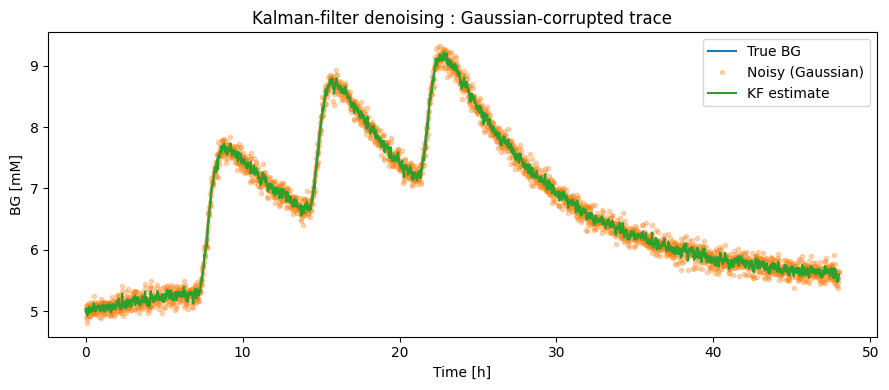

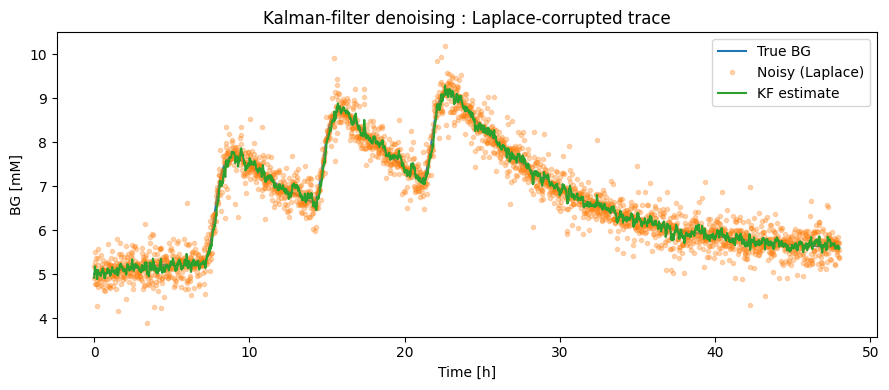

In [10]:
# ---------------------------------------------------------------------------
# Kalman-filter denoising of the CGM traces
# ---------------------------------------------------------------------------
from util.filter import KalmanFilter

# 1.  Model matrices for a *random-walk* state model  Gk = Gk-1 + wk
F = np.array([[1.0]])                 # state-transition  (identity)
H = np.array([[1.0]])                 # observation       (direct read-out)

Q = np.array([[Q_STD**2]])            # process-noise variance (scalar)
R_gauss   = np.array([[SIGMA_G**2]])  # measurement variance for Gaussian sensor
R_laplace = np.array([[2*B_LAPLACE**2]])
# Laplace(b) has variance 2 b², so we approximate it with an equivalent Gaussian
# in order to keep the KF mathematically valid.

# 2.  Initial priors (start at first reading, with conservative uncertainty)
x0_gauss = np.array([bg_gauss_noisy[0]])
P0_gauss = np.array([[SIGMA_G**2]])

x0_lap   = np.array([bg_laplace_noisy[0]])
P0_lap   = np.array([[2*B_LAPLACE**2]])

kf_gauss = KalmanFilter(F, Q, H, R_gauss,   x0_gauss, P0_gauss)
kf_lap   = KalmanFilter(F, Q, H, R_laplace, x0_lap,   P0_lap)

# 3.  Run the two filters
est_gauss_kf   = np.empty_like(bg_gauss_noisy)
est_laplace_kf = np.empty_like(bg_laplace_noisy)

for k, z in enumerate(bg_gauss_noisy):
    x_hat, _ = kf_gauss.step(z)          # predict → update
    est_gauss_kf[k] = x_hat.squeeze()    # store scalar

for k, z in enumerate(bg_laplace_noisy):
    x_hat, _ = kf_lap.step(z)
    est_laplace_kf[k] = x_hat.squeeze()

# 4.  Quality check
rmse_gauss_kf   = np.sqrt(np.mean((est_gauss_kf   - bg_true)**2))
rmse_laplace_kf = np.sqrt(np.mean((est_laplace_kf - bg_true)**2))
print(f"Kalman-filter RMSE : Gaussian noise : {rmse_gauss_kf:0.3f} mM")
print(f"Kalman-filter RMSE : Laplace noise  : {rmse_laplace_kf:0.3f} mM")

# 5.  Visual comparison
plt.figure(figsize=(9,4))
plt.plot(time_hours, bg_true,        label='True BG')
plt.plot(time_hours, bg_gauss_noisy, '.', alpha=0.30, label='Noisy (Gaussian)')
plt.plot(time_hours, est_gauss_kf,   label='KF estimate')
plt.xlabel('Time [h]'); plt.ylabel('BG [mM]')
plt.title('Kalman-filter denoising : Gaussian-corrupted trace')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(time_hours, bg_true,          label='True BG')
plt.plot(time_hours, bg_laplace_noisy, '.', alpha=0.30, label='Noisy (Laplace)')
plt.plot(time_hours, est_laplace_kf,    label='KF estimate')
plt.xlabel('Time [h]'); plt.ylabel('BG [mM]')
plt.title('Kalman-filter denoising : Laplace-corrupted trace')
plt.legend(); plt.tight_layout(); plt.show()


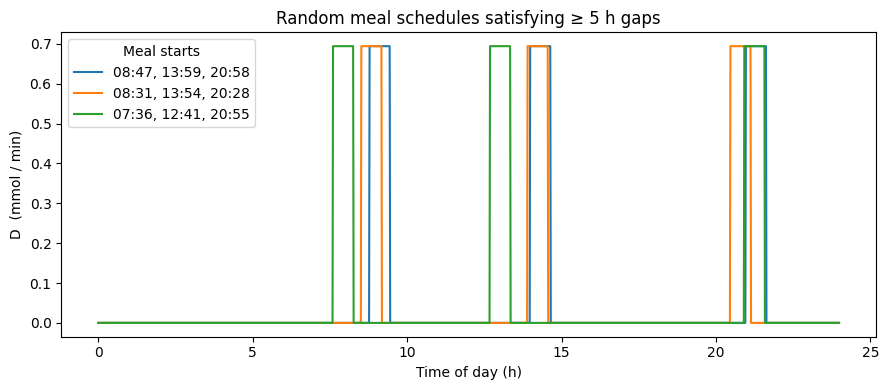

In [11]:
def sample_meal_times(rng=None,
                      first_window=(7 * 60, 11 * 60),   # 07:00 – 11:00
                      second_window=(12 * 60, 14 * 60), # 12:00 – 14:00
                      third_window=(18 * 60, 21 * 60),  # 18:00 – 21:00
                      min_gap=5 * 60):                  # ≥ 5 h between meals
    """
    Draw three meal–start times (in minutes after midnight) that
    satisfy the user’s constraints.
    """
    rng = np.random.default_rng() if rng is None else rng

    while True:
        t1 = rng.integers(*first_window)
        t2 = rng.integers(*second_window)
        t3 = rng.integers(*third_window)

        if (t2 - t1) >= min_gap and (t3 - t2) >= min_gap:
            return int(t1), int(t2), int(t3)


def make_D_of_t(meal_times,
                D_rate=5 * (1000 / 180) / 40,  # mmol · min⁻¹
                meal_duration=40):
    """
    Return a function D_of_t(t_min) that is piece-wise constant.
    """
    meal_times = np.asarray(meal_times)

    def D_of_t(t_min):
        # works for scalar or NumPy array input
        t = np.asarray(t_min)
        active = ((t[:, None] if t.ndim else t) >= meal_times) & (
            (t[:, None] if t.ndim else t) < (meal_times + meal_duration))
        return D_rate * active.sum(axis=-1)

    return D_of_t


# ------------------------------------------------------------------
# Demo: show three random scenarios in a single day
# ------------------------------------------------------------------
rng = np.random.default_rng(2025)
scenarios = [sample_meal_times(rng) for _ in range(3)]

t = np.arange(24 * 60)  # 0 … 1440 min (one day)

plt.figure(figsize=(9, 4))
for mt in scenarios:
    D_func = make_D_of_t(mt)
    D_trace = D_func(t)
    label = f"{mt[0]//60:02d}:{mt[0]%60:02d}, " \
            f"{mt[1]//60:02d}:{mt[1]%60:02d}, " \
            f"{mt[2]//60:02d}:{mt[2]%60:02d}"
    plt.plot(t / 60, D_trace, label=label)

plt.xlabel("Time of day (h)")
plt.ylabel("D  (mmol / min)")
plt.title("Random meal schedules satisfying ≥ 5 h gaps")
plt.legend(title="Meal starts")
plt.tight_layout()


In [48]:
# ---------------------------------------------------------------------------------
# Build train / test datasets with *random* meal schedules + sensor noise
# ---------------------------------------------------------------------------------
import numpy as np
from scipy.integrate import ode
import torch
from pathlib import Path
from tqdm.auto import tqdm

# ---------------- configuration --------------------------------------------------
rng         = np.random.default_rng(seed=2025)
N_TRAIN     = 2_00        # how many traces to simulate for training
N_TEST      = 400          # how many for final evaluation
SIGMA_G     = 0.10         # Gaussian σ  (mmol/L)
B_LAPLACE   = 0.20         # Laplace  b  (mmol/L)
t_end       = 48 * 60      # minutes (48 h)
dt          = 1            # 1-min sampling
ts          = np.arange(0, t_end + dt, dt)
T           = ts.size

# ---------------- handy wrappers -------------------------------------------------
def simulate_bg_trace(meal_times, p=params, x0=x0):
    """
    Integrate the 6-dim glucose–insulin model for a *single* day,
    replacing D_of_t with a schedule specific to `meal_times`.
    Returns BG(t) as a (T,) NumPy array [mmol/L].
    """
    # 1. build a meal-specific D_of_t -------------------------
    D_RATE        = 5 * (1000/180) / 40      # mmol · min⁻¹
    meal_times    = np.asarray(meal_times)
    def D_of_t_local(t_min):
        return sum(D_RATE for m in meal_times if m <= t_min < m + 40)

    # 2. patch it into the RHS via a closure -----------------
    def rhs(t, x):
        return glucose_insulin_model(t, x, p)  # glucose_insulin_model uses the *current* D_of_t
    # monkey-patch the name seen by glucose_insulin_model
    globals()['D_of_t'] = D_of_t_local

    # 3. integrate ------------------------------------------
    solver = ode(rhs).set_integrator('dopri5')
    solver.set_initial_value(x0, 0.0)

    xs = np.zeros((T, 6), dtype=np.float32)
    xs[0] = x0
    for k in range(1, T):
        xs[k] = solver.integrate(ts[k])
    return xs[:, 0]                  # blood-glucose only (state #0)

def make_split(N, desc):
    """
    Simulate N traces → (true BG, Gaussian-noisy, Laplace-noisy, meal_times)
    """
    bg_true  = np.zeros((N, T), dtype=np.float32)
    z_gauss  = np.zeros_like(bg_true)
    z_lap    = np.zeros_like(bg_true)
    meals    = np.zeros((N, 3), dtype=np.int16)

    for i in tqdm(range(N), desc=desc):
        mt        = sample_meal_times(rng)
        meals[i]  = mt
        bg        = simulate_bg_trace(mt)
        bg_true[i]   = bg
        z_gauss[i]   = bg + rng.normal(0.0, SIGMA_G,  bg.shape)
        z_lap[i]     = bg + rng.laplace(0.0, B_LAPLACE, bg.shape)

    return bg_true, z_gauss, z_lap, meals

# ---------------- run the simulations -------------------------------------------
train_true, z_train_g, z_train_l, meal_train = make_split(N_TRAIN, "train  traces")
test_true,  z_test_g,  z_test_l,  meal_test  = make_split(N_TEST,  "test   traces")

# ---------------- save to disk ---------------------------------------------------
out_dir = Path("data_knet_random")
out_dir.mkdir(exist_ok=True)

np.savez_compressed(out_dir / "train_gauss.npz",
                    z=z_train_g, x=train_true, meal=meal_train)
np.savez_compressed(out_dir / "train_laplace.npz",
                    z=z_train_l, x=train_true, meal=meal_train)
np.savez_compressed(out_dir / "test_gauss.npz",
                    z=z_test_g,  x=test_true,  meal=meal_test)
np.savez_compressed(out_dir / "test_laplace.npz",
                    z=z_test_l,  x=test_true,  meal=meal_test)

print(f"✅  Saved to {out_dir.resolve()}")
# ---------------- quick PyTorch wrappers ----------------------------------------
class GlucoseDataset(torch.utils.data.Dataset):
    def __init__(self, z, x_true):
        self.z = torch.as_tensor(z, dtype=torch.float32)
        self.x = torch.as_tensor(x_true, dtype=torch.float32)

    def __len__(self):  return self.z.shape[0]
    def __getitem__(self, idx):  return self.z[idx], self.x[idx]

train_x = np.vstack([z_train_g, z_train_l])   # shape: (2 * N_TRAIN,  T)
test_x  = np.vstack([z_test_g,  z_test_l ])   # shape: (2 * N_TEST,   T)

# (2) replicate the true signal to match
train_y = np.vstack([train_true,    train_true])   # shape: (2 * N_TRAIN,  T)
test_y  = np.vstack([test_true,     test_true ])   # shape: (2 * N_TEST,   T)

print("train_x / train_y shapes:", train_x.shape, train_y.shape)
print(" test_x /  test_y shapes:", test_x.shape,  test_y.shape)

# (3) if you want torch Datasets directly on these:
train_ds = GlucoseDataset(train_x, train_y)
test_ds  = GlucoseDataset(test_x,  test_y)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                       shuffle=True, drop_last=True)

test   traces: 100%|██████████| 400/400 [01:07<00:00,  5.93it/s]


✅  Saved to /home/ash/Desktop/kalman-net/src/data_knet_random
train_x / train_y shapes: (400, 2881) (400, 2881)
 test_x /  test_y shapes: (800, 2881) (800, 2881)


In [50]:
data_dir = "/home/ash/Desktop/kalman-net/src/data_knet_random"
train_g = np.load(f"{data_dir}/train_gauss.npz")
train_l = np.load(f"{data_dir}/train_laplace.npz")
test_g  = np.load(f"{data_dir}/test_gauss.npz")
test_l  = np.load(f"{data_dir}/test_laplace.npz")

z_train_g, train_true = train_g['z'], train_g['x']
z_train_l             = train_l['z']
z_test_g,  test_true  = test_g['z'],  test_g['x']
z_test_l              = test_l['z']


# Build PyTorch datasets and loaders
batch_size = 32
train_ds = np.vstack([z_train_g, z_train_l]), np.vstack([train_true, train_true])
print(len(train_ds), len(train_ds[0]))
print(train_ds[0].shape, train_ds[1].shape)
train_dl_x = torch.utils.data.DataLoader(train_ds[0], batch_size=batch_size, shuffle=True, drop_last=False)
train_dl_y = torch.utils.data.DataLoader(train_ds[1], batch_size=batch_size, shuffle=True, drop_last=False)

print(len(train_dl))

test_ds  = np.vstack([z_test_g, z_test_l]), np.vstack([test_true, test_true])

2 400
(400, 2881) (400, 2881)
12


Epoch 01 | train MSE = 0.0179
Epoch 02 | train MSE = 0.0173
Epoch 03 | train MSE = 0.0183
Epoch 04 | train MSE = 0.0170
Epoch 05 | train MSE = 0.0165


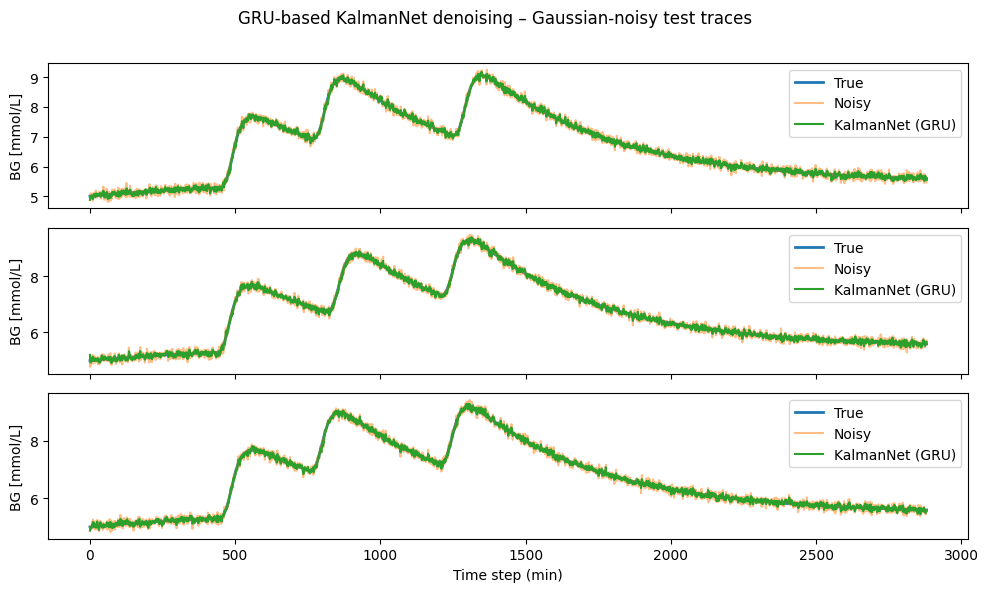

In [59]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ------------------- 1. load your data -----------------------------
# Assumes you already have:
# - train_x, train_y = (2 * N_TRAIN, T)
# - test_x,  test_y  = (2 * N_TEST,  T)
# - SIGMA_G = std. of Gaussian noise

# ------------------- 2. Dataset + DataLoader -----------------------
class GlucoseDataset(torch.utils.data.Dataset):
    def __init__(self, z, x_true):
        self.z = torch.as_tensor(z, dtype=torch.float32)
        self.x = torch.as_tensor(x_true, dtype=torch.float32)

    def __len__(self): return self.z.shape[0]
    def __getitem__(self, idx): return self.z[idx], self.x[idx]

batch_size = 256
train_ds = GlucoseDataset(train_x, train_y)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                       shuffle=True, drop_last=True)
test_ds = GlucoseDataset(test_x, test_y)

# ------------------- 3. GainGRU Network ----------------------------
class GainGRU(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=hidden, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, z_seq):  # (1, T, 1)
        out, _ = self.gru(z_seq)     # (1, T, hidden)
        gains = self.fc(out)         # (1, T, 1)
        return gains.squeeze(-1)     # (1, T)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
gain_net = GainGRU().to(device)

# ------------------- 4. Kalman Filter Constants --------------------
F = torch.tensor([[1.0]], dtype=torch.float32, device=device)
Q = torch.tensor([[0.01]], dtype=torch.float32, device=device)
H = torch.tensor([[1.0]], dtype=torch.float32, device=device)
R = torch.tensor([[SIGMA_G**2]], dtype=torch.float32, device=device)
eye1 = torch.eye(1, device=device)

# ------------------- 5. Training Loop -------------------------------
epochs = 5
lr = 1e-4
grad_clip = 1.0
opt = optim.Adam(gain_net.parameters(), lr=lr)
lossf = nn.MSELoss()

for ep in range(1, epochs + 1):
    gain_net.train()
    running_loss = 0.0

    for z_batch, x_batch in train_dl:
        z_batch = z_batch.to(device)
        x_batch = x_batch.to(device)
        B, T = z_batch.shape
        batch_loss = 0.0

        for b in range(B):
            z_seq = z_batch[b].view(1, T, 1)             # (1, T, 1)
            K_seq = gain_net(z_seq).squeeze(0)           # (T,)
            x_hat = z_seq[0, 0].view(1, 1)                # init state
            P     = torch.tensor([[5.0]], device=device)

            est = []
            for t in range(T):
                x_pred = F @ x_hat
                P_pred = F @ P @ F.T + Q

                z_t = z_seq[0, t].view(1, 1)
                K_t = K_seq[t].view(1, 1)

                x_hat = x_pred + K_t @ (z_t - H @ x_pred)
                P     = (eye1 - K_t @ H) @ P_pred
                est.append(x_hat.view(-1))

            est = torch.stack(est).squeeze()             # (T,)
            trace_loss = lossf(est, x_batch[b])
            batch_loss += trace_loss

        batch_loss = batch_loss / B
        opt.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(gain_net.parameters(), grad_clip)
        opt.step()
        running_loss += batch_loss.item()

    print(f"Epoch {ep:02d} | train MSE = {running_loss / len(train_dl):.4f}")

# ------------------- 6. Evaluation ---------------------------------
def run_gru_filter(z_trace_np):
    z_trace = torch.tensor(z_trace_np, dtype=torch.float32, device=device).view(1, -1, 1)  # (1, T, 1)
    K_seq = gain_net(z_trace).squeeze(0)                                                   # (T,)
    x_hat = z_trace[0, 0].view(1, 1)
    P = torch.tensor([[5.0]], device=device)
    est = []

    with torch.no_grad():
        for t in range(z_trace.shape[1]):
            x_pred = F @ x_hat
            P_pred = F @ P @ F.T + Q

            z_t = z_trace[0, t].view(1, 1)
            K_t = K_seq[t].view(1, 1)

            x_hat = x_pred + K_t @ (z_t - H @ x_pred)
            P     = (eye1 - K_t @ H) @ P_pred
            est.append(x_hat.item())

    return np.array(est)

# ------------------- 7. Plotting -----------------------------------
n_gauss = test_x.shape[0] // 2
idxs = np.random.choice(n_gauss, 3, replace=False)
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for ax, i in zip(axes, idxs):
    z = test_x[i]
    x_true = test_y[i]
    est = run_gru_filter(z)

    ax.plot(x_true, label='True', lw=2)
    ax.plot(z, label='Noisy', alpha=0.5)
    ax.plot(est, label='KalmanNet (GRU)', lw=1.5)
    ax.set_ylabel('BG [mmol/L]')
    ax.legend()

axes[-1].set_xlabel('Time step (min)')
plt.suptitle('GRU-based KalmanNet denoising – Gaussian-noisy test traces')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
